## Learn model
## Content
  * Load data
  * Select features
  * Learning
    * linear
    * lasso
    * ridge
    * elastic net
    * Xgboost
    * MLP
  * Compare results

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from pymongo import MongoClient
from keras import metrics
import warnings
import sklearn.linear_model as linear_model
%matplotlib inline

warnings.filterwarnings('ignore')

/home/siarhei/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
MONGODB_URL = os.environ['MONGODB_URI']
client = MongoClient(MONGODB_URL)
db = client.get_default_database()

In [3]:
data = db["notebook"].find({})
full_frame = pd.DataFrame(list(data))
full_frame.drop(columns=["_id"], inplace=True)
full_frame.shape

(2928, 79)

### Select features

In [4]:
features = ['Neighborhood',
 'BsmtQual',
 'GarageFinish',
 'GarageType',
 'MSSubClass',
 'Foundation',
 'FireplaceQu',
 'MSZoning',
 'Exterior1st',
 'BsmtFinType1',
 'GrLivArea',
 'GarageCars',
 'TotalBsmtSF',
 'YearBuilt',
 'YearRemodAdd',
 'FullBath',
 'Fireplaces',
 'MasVnrArea',
 'BsmtFinSF1',
 'WoodDeckSF']

to_log_transform = ['GrLivArea', 'Fireplaces', 'WoodDeckSF', 'GarageFinish', 'MSZoning']

to_pow_transform = ['YearBuilt', 'YearRemodAdd', 'BsmtQual', 'Foundation', 'BsmtFinType1']

to_boolean_transform = {
    'TotalBsmtSF': {'new_feature_name': 'HasBasement', 'threshold': 0},
    'GarageArea': {'new_feature_name': 'HasGarage', 'threshold': 0},
    '2ndFlrSF': {'new_feature_name': 'Has2ndFloor', 'threshold': 0},
    'MasVnrArea': {'new_feature_name': 'HasMasVnr', 'threshold': 0},
    'WoodDeckSF': {'new_feature_name': 'HasWoodDeck', 'threshold': 0},
    'OpenPorchSF': {'new_feature_name': 'HasPorch', 'threshold': 0},
    'PoolArea': {'new_feature_name': 'HasPool', 'threshold': 0},
    'YearBuilt': {'new_feature_name': 'IsNew', 'threshold': 2000},
}

## Learn model

In [5]:
def log_transformation(frame, feature):
    new_feature_name = new_log_feature_name(feature)
    frame[new_feature_name] = np.log1p(frame[feature].values)

def new_quadratic_feature_name(feature):
    return feature+'2'

def new_log_feature_name(feature):
    return feature+'Log'
    
def quadratic(frame, feature):
    new_feature_name = new_quadratic_feature_name(feature)
    frame[new_feature_name] = frame[feature]**2
    
def boolean_transformation(frame, feature, new_feature_name, threshold):
    frame[new_feature_name] = frame[feature].apply(lambda x: 1 if x > threshold else 0)
    
def error(actual, predicted):
    actual = np.log(actual)
    predicted = np.log(predicted)
    return np.sqrt(np.sum(np.square(actual-predicted))/len(actual))

def error_mse(actual, predicted):
    actual = (actual)
    predicted = (predicted)
    return np.sqrt(np.sum(np.square(actual-predicted))/len(actual))

In [6]:
added_boolean_columns = [to_boolean_transform[o]['new_feature_name'] for o in to_boolean_transform.keys()]

added_quadratic_columns = list(map(new_quadratic_feature_name, to_pow_transform))

added_log_columns = list(map(new_log_feature_name, to_log_transform))

def transform_before_learn(frame, to_log_transform, to_pow_transform, to_boolean_transform):

    for c in to_log_transform:
        log_transformation(frame, c)

    for c in to_pow_transform:
        quadratic(frame, c)

    for c in to_boolean_transform.keys():
        boolean_transformation(frame, c, to_boolean_transform[c]['new_feature_name'], 
                               to_boolean_transform[c]['threshold']) 


transform_before_learn(full_frame, to_log_transform, to_pow_transform, to_boolean_transform)

df_train = full_frame[:1460]
df_test = full_frame[1460:]

# features = list(set(features) - set(to_log_transform) - set(to_pow_transform))

In [7]:
features_full_list = features + added_boolean_columns + added_quadratic_columns + added_log_columns

## Out liars

In [8]:
df_train_cleaned = df_train
#df_train_cleaned = df_train.drop(df_train[df_train['Id'] == 1299].index)
#df_train_cleaned = df_train.drop(df_train[df_train['Id'] == 524].index)

### LinearRegression

In [9]:
X = df_train_cleaned[features_full_list]
Y = df_train_cleaned['SalePrice'].values

full_X = df_train[features_full_list]
full_Y = df_train['SalePrice'].values

linear = linear_model.LinearRegression()
linear.fit(X, np.log1p(Y))

Ypred_linear = np.expm1(linear.predict(full_X))
print(error(full_Y, Ypred_linear))
print(error_mse(full_Y, Ypred_linear))

0.14492516236618694
32156.676842024903


#### test dataset

In [10]:
full_test_X = df_test[features_full_list]
test_Y = df_test['SalePrice'].values

test_pred = np.expm1(linear.predict(full_test_X))

print(error(test_Y, test_pred))
print(error_mse(test_Y, test_pred))

0.16275362497583534
28298.392776202723


### LassoCV

In [11]:
X = df_train_cleaned[features_full_list]
Y = df_train_cleaned['SalePrice'].values

full_X = df_train[features_full_list]
full_Y = df_train['SalePrice'].values

lasso = linear_model.LassoCV()
lasso.fit(X, np.log1p(Y))

Ypred_lasso = np.expm1(lasso.predict(full_X))
print(error(full_Y, Ypred_lasso))
print(error_mse(full_Y, Ypred_linear))

0.21865280164764717
32156.676842024903


#### test dataset

In [12]:
full_test_X = df_test[features_full_list]
test_Y = df_test['SalePrice'].values

test_pred = np.expm1(lasso.predict(full_test_X))

print(error(test_Y, test_pred))
print(error_mse(test_Y, test_pred))

0.22421492143268326
44106.27607404202


### RidgeCV

In [13]:
X = df_train_cleaned[features_full_list]
Y = df_train_cleaned['SalePrice'].values

full_X = df_train[features_full_list]
full_Y = df_train['SalePrice'].values

ridge = linear_model.RidgeCV()
ridge.fit(X, np.log1p(Y))
Ypred_ridge = np.expm1(ridge.predict(full_X))
print(error(full_Y,Ypred_ridge))
print(error_mse(full_Y, Ypred_ridge))

0.14511945815042993
32240.450125379073


#### test dataset

In [14]:
full_test_X = df_test[features_full_list]
test_Y = df_test['SalePrice'].values

test_pred = np.expm1(ridge.predict(full_test_X))

print(error(test_Y, test_pred))
print(error_mse(test_Y, test_pred))

0.16163659581114517
28263.786258830925


### ElasticNetCV

In [15]:
X = df_train_cleaned[features_full_list]
Y = df_train_cleaned['SalePrice'].values

full_X = df_train[features_full_list]
full_Y = df_train['SalePrice'].values

elasticNet = linear_model.ElasticNetCV()
elasticNet.fit(X, np.log1p(Y))
Ypred_elasticNet = np.expm1(elasticNet.predict(full_X))
print(error(full_Y,Ypred_elasticNet))
print(error_mse(full_Y, Ypred_elasticNet))

0.21865577872283973
52064.05404640965


#### test dataset

In [16]:
full_test_X = df_test[features_full_list]
test_Y = df_test['SalePrice'].values

test_pred = np.expm1(elasticNet.predict(full_test_X))

print(error(test_Y, test_pred))
print(error_mse(test_Y, test_pred))

0.22421770572499905
44106.98292298739


### Xgboost

In [17]:
import xgboost as xgb

In [18]:
X = df_train_cleaned[features_full_list]
Y = df_train_cleaned['SalePrice'].values

full_X = df_train[features_full_list]
full_Y = df_train['SalePrice'].values

In [19]:
X_tr, X_val, y_tr, y_val = train_test_split(X, np.log1p(Y), random_state = 42, test_size=0.20)

eval_set = [(X_val, y_val)]

In [20]:
model_xgb = xgb.XGBRegressor(n_estimators=1000, max_depth=2, learning_rate=0.1)
model_xgb.fit(X_tr, y_tr, eval_metric="rmse", early_stopping_rounds=500, eval_set=eval_set, verbose=True)
# model_xgb.fit(X, np.log1p(Y))

[0]	validation_0-rmse:10.3548
Will train until validation_0-rmse hasn't improved in 500 rounds.
[1]	validation_0-rmse:9.31671
[2]	validation_0-rmse:8.38255
[3]	validation_0-rmse:7.5463
[4]	validation_0-rmse:6.7915
[5]	validation_0-rmse:6.11422
[6]	validation_0-rmse:5.50272
[7]	validation_0-rmse:4.95392
[8]	validation_0-rmse:4.45849
[9]	validation_0-rmse:4.01318
[10]	validation_0-rmse:3.61203
[11]	validation_0-rmse:3.25138
[12]	validation_0-rmse:2.92657
[13]	validation_0-rmse:2.63352
[14]	validation_0-rmse:2.3705
[15]	validation_0-rmse:2.13535
[16]	validation_0-rmse:1.92279
[17]	validation_0-rmse:1.73211
[18]	validation_0-rmse:1.56099
[19]	validation_0-rmse:1.40463
[20]	validation_0-rmse:1.2656
[21]	validation_0-rmse:1.14147
[22]	validation_0-rmse:1.02844
[23]	validation_0-rmse:0.927126
[24]	validation_0-rmse:0.837116
[25]	validation_0-rmse:0.755773
[26]	validation_0-rmse:0.682823
[27]	validation_0-rmse:0.616864
[28]	validation_0-rmse:0.558127
[29]	validation_0-rmse:0.505813
[30]	valida

[252]	validation_0-rmse:0.134511
[253]	validation_0-rmse:0.134466
[254]	validation_0-rmse:0.134449
[255]	validation_0-rmse:0.134327
[256]	validation_0-rmse:0.134347
[257]	validation_0-rmse:0.13432
[258]	validation_0-rmse:0.134351
[259]	validation_0-rmse:0.134318
[260]	validation_0-rmse:0.134308
[261]	validation_0-rmse:0.134268
[262]	validation_0-rmse:0.134216
[263]	validation_0-rmse:0.134191
[264]	validation_0-rmse:0.134267
[265]	validation_0-rmse:0.13425
[266]	validation_0-rmse:0.134296
[267]	validation_0-rmse:0.134221
[268]	validation_0-rmse:0.134285
[269]	validation_0-rmse:0.134288
[270]	validation_0-rmse:0.134242
[271]	validation_0-rmse:0.134254
[272]	validation_0-rmse:0.134235
[273]	validation_0-rmse:0.134168
[274]	validation_0-rmse:0.134248
[275]	validation_0-rmse:0.134179
[276]	validation_0-rmse:0.134196
[277]	validation_0-rmse:0.1342
[278]	validation_0-rmse:0.134189
[279]	validation_0-rmse:0.134199
[280]	validation_0-rmse:0.134194
[281]	validation_0-rmse:0.134165
[282]	validati

[502]	validation_0-rmse:0.135466
[503]	validation_0-rmse:0.135447
[504]	validation_0-rmse:0.135432
[505]	validation_0-rmse:0.135431
[506]	validation_0-rmse:0.13543
[507]	validation_0-rmse:0.135179
[508]	validation_0-rmse:0.13513
[509]	validation_0-rmse:0.135162
[510]	validation_0-rmse:0.135193
[511]	validation_0-rmse:0.135233
[512]	validation_0-rmse:0.135252
[513]	validation_0-rmse:0.135235
[514]	validation_0-rmse:0.135306
[515]	validation_0-rmse:0.135393
[516]	validation_0-rmse:0.135393
[517]	validation_0-rmse:0.135413
[518]	validation_0-rmse:0.135399
[519]	validation_0-rmse:0.135417
[520]	validation_0-rmse:0.135416
[521]	validation_0-rmse:0.135454
[522]	validation_0-rmse:0.135472
[523]	validation_0-rmse:0.135435
[524]	validation_0-rmse:0.135436
[525]	validation_0-rmse:0.135436
[526]	validation_0-rmse:0.135432
[527]	validation_0-rmse:0.135498
[528]	validation_0-rmse:0.135515
[529]	validation_0-rmse:0.13559
[530]	validation_0-rmse:0.13559
[531]	validation_0-rmse:0.135546
[532]	validati

[751]	validation_0-rmse:0.135998
[752]	validation_0-rmse:0.136069
[753]	validation_0-rmse:0.136054
[754]	validation_0-rmse:0.136061
[755]	validation_0-rmse:0.136026
[756]	validation_0-rmse:0.136056
[757]	validation_0-rmse:0.13606
[758]	validation_0-rmse:0.136058
[759]	validation_0-rmse:0.136084
[760]	validation_0-rmse:0.136119
[761]	validation_0-rmse:0.136087
[762]	validation_0-rmse:0.136086
[763]	validation_0-rmse:0.135977
[764]	validation_0-rmse:0.135903
[765]	validation_0-rmse:0.135878
[766]	validation_0-rmse:0.135889
[767]	validation_0-rmse:0.135918
[768]	validation_0-rmse:0.135911
[769]	validation_0-rmse:0.135915
[770]	validation_0-rmse:0.135971
[771]	validation_0-rmse:0.135955
[772]	validation_0-rmse:0.135947
[773]	validation_0-rmse:0.13597
[774]	validation_0-rmse:0.135955
[775]	validation_0-rmse:0.135939
[776]	validation_0-rmse:0.135978
[777]	validation_0-rmse:0.135981
[778]	validation_0-rmse:0.135981
[779]	validation_0-rmse:0.136044
[780]	validation_0-rmse:0.136026
[781]	valida

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=2, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [21]:
Ypred_xgb = np.expm1(model_xgb.predict(full_X))
print(error(full_Y, Ypred_xgb))
print(error_mse(full_Y, Ypred_xgb))

0.08910122035234937
17764.423419253515


#### test dataset

In [22]:
full_test_X = df_test[features_full_list]
test_Y = df_test['SalePrice'].values

test_pred = np.expm1(model_xgb.predict(full_test_X))

print(error(test_Y, test_pred))
print(error_mse(test_Y, test_pred))

0.15141766268525939
24416.234424868107


## MLP

In [23]:
import tensorflow as tf
from keras.layers import Dense
from keras.models import Sequential
from keras.regularizers import l1
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint 
from keras.callbacks import LearningRateScheduler
from keras import optimizers
from sklearn.preprocessing import StandardScaler
from keras import backend as K
from keras import losses

tf.logging.set_verbosity(tf.logging.ERROR)
tf.set_random_seed(42)
np.random.seed(42)

In [24]:
mlp_feed = df_train[features]

In [25]:
X_tr, X_val, y_tr, y_val = train_test_split(mlp_feed, np.log1p(Y), random_state = 7, test_size=0.20)

In [26]:
model = Sequential()
model.add(Dense(10, input_dim=mlp_feed.shape[1], activation='relu'))
model.add(Dense(30, activation='relu'))
model.add(Dense(40, activation='relu'))
model.add(Dense(1))

# adam = optimizers.Adam()
# model.compile(loss = losses.mean_squared_error, optimizer = adam)

model.compile(optimizer ='adam', loss = 'mean_squared_error', metrics =[metrics.mae])

In [27]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_2 (Dense)              (None, 30)                330       
_________________________________________________________________
dense_3 (Dense)              (None, 40)                1240      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 41        
Total params: 1,821
Trainable params: 1,821
Non-trainable params: 0
_________________________________________________________________


In [28]:
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=10, verbose=1, mode='auto')
checkpointer = ModelCheckpoint(filepath="best_weights.hdf5", verbose=0, save_best_only=True)  # save best model

In [29]:
hist = model.fit(X_tr, y_tr, 
                 batch_size=1, 
                 validation_data = (X_val, y_val), 
                 callbacks=[monitor, checkpointer], 
                 verbose=1, 
                 epochs=150)

Train on 1168 samples, validate on 292 samples
Epoch 1/150
1168/1168 [==============================] - 7s 6ms/step - loss: 101.8715 - mean_absolute_error: 4.0191 - val_loss: 5.5625 - val_mean_absolute_error: 1.8867
Epoch 2/150
1168/1168 [==============================] - 6s 5ms/step - loss: 6.3135 - mean_absolute_error: 1.6550 - val_loss: 2.3603 - val_mean_absolute_error: 1.0181
Epoch 3/150
1168/1168 [==============================] - 6s 5ms/step - loss: 8.1141 - mean_absolute_error: 1.5612 - val_loss: 6.4338 - val_mean_absolute_error: 2.2930
Epoch 4/150
1168/1168 [==============================] - 6s 5ms/step - loss: 59.7490 - mean_absolute_error: 3.1175 - val_loss: 1.8395 - val_mean_absolute_error: 0.7232
Epoch 5/150
1168/1168 [==============================] - 5s 4ms/step - loss: 5.4619 - mean_absolute_error: 1.3971 - val_loss: 8.6805 - val_mean_absolute_error: 2.7837
Epoch 6/150
1168/1168 [==============================] - 6s 5ms/step - loss: 2.4705 - mean_absolute_error: 1.1758 -

In [30]:
model.load_weights('best_weights.hdf5')  # load weights from best model

# Measure accuracy
Ypred_mlp = np.expm1(model.predict(mlp_feed))
print(error(df_train['SalePrice'].values,Ypred_mlp))
print(error_mse(df_train['SalePrice'].values, Ypred_mlp))

21.826026600974455
6123900.353947401


#### test dataset

In [31]:
full_test_X = df_test[features]
test_Y = df_test['SalePrice'].values

test_pred = np.expm1(model.predict(full_test_X))

print(error(test_Y, test_pred))
print(error_mse(test_Y, test_pred))

21.966480070067792
4454944.799270675


## Compare results

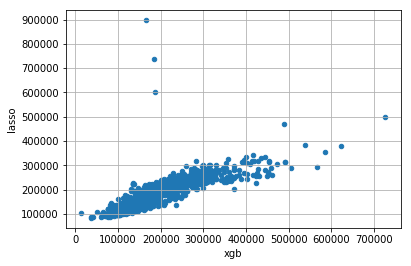

In [32]:
predictions = pd.DataFrame({"xgb":Ypred_xgb, "lasso":Ypred_lasso})
predictions.plot(x = "xgb", y = "lasso", kind = "scatter", grid=True)

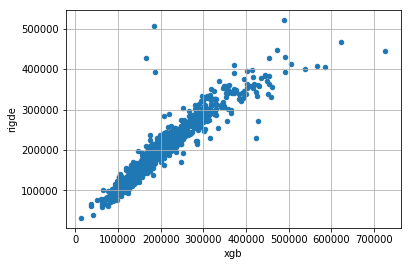

In [33]:
predictions = pd.DataFrame({"xgb":Ypred_xgb, "rigde":Ypred_ridge})
predictions.plot(x = "xgb", y = "rigde", kind = "scatter", grid=True)

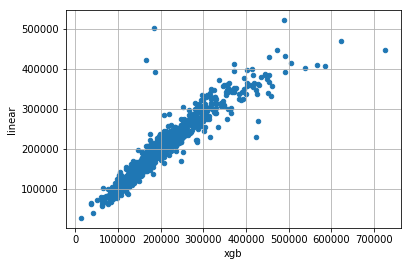

In [34]:
predictions = pd.DataFrame({"xgb":Ypred_xgb, "linear":Ypred_linear})
predictions.plot(x = "xgb", y = "linear", kind = "scatter", grid=True)